In [1]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# To switch between DR15 and DR17, change the config.setRelease line and any uses of drpall (v2_4_3 for DR15 and v3_1_1 for 
# DR17). The v2_4_3 file has "-Copy1" at the end of its name so it is not accidentally used by any other notebook. Also change 
# figure titles and file names in savefig lines (these can both be changed by the variable named "version."
#
# v3 introduces updated error propagation and actually writing the ivar values to the FITS files. The issues with v2 were 
# that the variables used for its metallicity inverse variance calculations were likely not independent of each other, 
# and the line of metallicities_iterator that writes the ivar values to each FITS file was commented out.

In [1]:
# Import packages

import marvin
from marvin.tools.maps import Maps
from marvin.tools import Image
from marvin import config
config.setRelease('DR17')

import numpy as np
import numpy.ma as ma
from numpy import log10, pi

import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.constants as const

import math

import pyneb as pn

/home/nbrunaci/.local/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [2]:
# Takes in plate and IFU numbers of a galaxy, returns nested dictionary of each relevent emission line's flux (UNCORRECTED
# FOR DUST EXTINCTION) and inverse variance in masked arrays
# Called by addDiagnostics_Pilyugin function
# Could probably by merged with the addDiagnostics function
def getDataMaps_Pilyugin(plateifu):
    maps = Maps(plateifu)
    
    # Obtaining redshift data from drpall fits file
    with fits.open('drpall-v3_1_1.fits', memmap=True) as drpall:
        tbdata = drpall[1].data
        ind = np.where(tbdata['plateifu'] == plateifu)
        redshift = tbdata['nsa_z'][ind][0]# This [0] is here because each z value seems to be in its own array for some reason
    
    # Observed emission lines
    HbF_map = maps["emline_gflux_hb_4862"]
    OII_map = maps["emline_gflux_oii_3727"]
    OIII_map = maps["emline_gflux_oiii_5008"]
    OIII2_map = maps["emline_gflux_oiii_4960"]
    NII_map = maps["emline_gflux_nii_6585"]
    NII2_map = maps["emline_gflux_nii_6549"]
    HaF_map = maps["emline_gflux_ha_6564"]
    OII2_map = maps["emline_gflux_oii_3729"]
    observed = [HbF_map,OII_map,OII2_map,OIII_map,OIII2_map,NII_map,NII2_map,HaF_map,]# Array of observed emission lines
    names = ['HbF','OII','OII2','OIII','OIII2','NII','NII2','HaF']# Array of names of observed emission lines
    
    # Array of masked flux arrays for observed emission lines
    observed_m = []
    for line in observed:
        observed_m.append(line.masked)
    
    # Array of masked inverse variance arrays for observed emission lines
    observed_ivar_m = []
    for line in observed:
        observed_ivar_m.append(ma.array(line.ivar,mask=line.mask))
    
    return{
        names[0]: {'flux': observed_m[0], 'ivar': observed_ivar_m[0]},
        names[1]: {'flux': observed_m[1], 'ivar': observed_ivar_m[1]},
        names[2]: {'flux': observed_m[2], 'ivar': observed_ivar_m[2]},
        names[3]: {'flux': observed_m[3], 'ivar': observed_ivar_m[3]},
        names[4]: {'flux': observed_m[4], 'ivar': observed_ivar_m[4]},
        names[5]: {'flux': observed_m[5], 'ivar': observed_ivar_m[5]},
        names[6]: {'flux': observed_m[6], 'ivar': observed_ivar_m[6]},
        names[7]: {'flux': observed_m[7], 'ivar': observed_ivar_m[7]},
        'z': redshift,# This did not end up being used
        'wavelength': [4862,3727,5008,4960,6585,6549,6564,3729]# Wavelength of each line
    }

In [3]:
# Takes in uncorrected observed line ivar and the coefficient its flux is being multiplied by in dustCorrect (based
# on line wavelength) and returns ivar for extinction-corrected observed line flux
def getDustCorrectedIvar(ivar,rc):
    
    # Extinction-corrected observed line ivar calculations:
    # Corrected observed flux = f(b) where b = uncorrected observed flux
    # f = b*c where c = RC.getCorrHb()
    # ivar_f = 1.0 / ( (df/do)**2/ivar_o + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_o) + o**2/(b**4*ivar_b) )
    ivar_corrected = ivar / rc**2
    
    return ivar_corrected

In [4]:
# Takes in output from getDataMaps_Pilyugin, returns those maps corrected for dust extinction
def dustCorrect(datamaps):
    RC = pn.RedCorr(law='CCM89')
    
    # Calculate the observed Ha/Hb flux ratio
    HaHb_obs = datamaps['HaF']['flux'] / datamaps['HbF']['flux']
    
    # Calculate correction coefficient based on theoretical Ha/Hb ratio
    RC.setCorr(HaHb_obs/2.86, 6563., 4861.)
    
    # De-redden emission line
    for index,line in enumerate(datamaps):
        if index<len(datamaps)-2:# To exclude the z and wavelength values
            corr = RC.getCorrHb(datamaps['wavelength'][index])
            datamaps[line]['flux'] = datamaps[line]['flux'] * corr
            # Updating error values
            datamaps[line]['ivar'] = getDustCorrectedIvar(datamaps[line]['ivar'],corr)
    
    return datamaps

In [5]:
# Takes in the three lines (in order) that go into each abundance diagnostic (line ratio), returns inverse variance array 
# for that diagnostic
# Called by addDiagnostics_Pilyugin function
# This is still functional but no longer needed, as we are not using the inverse variances for the line ratios. The parts of 
# addDiagnostics_Pilyugin that call this function are commented out.
def getDiagnosticIvar_Pilyugin(line1,line2,line3):
    
    # Fluxes
    nii = line1['flux']
    nii2 = line2['flux']
    b = line3['flux']
    
    # Inverse variances
    inii = line1['ivar']
    inii2 = line2['ivar']
    ib = line3['ivar']
    
    # NOTE: Error propagation calculations were done for N2, but the structure is identical for R2, N2, and R3.
    # N2 ivar calculations:
    # N2 = f(n,n2,b) where n=NII, n2=NII2, b=HbF
    # f = (n+n2)/b
    # ivar_f = 1.0 / ( (df/dn)**2/ivar_n + (df/dn2)**2/ivar_n2 + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_n) + 1.0/(b**2*ivar_n2) + (-(n+n2)/b**2)**2/ivar_b )
    ivar = 1.0 / (1.0/(b**2*inii) + 1.0/(b**2*inii2) + ((nii+nii2)/b**2)**2/ib)
    
    return ivar

In [6]:
# Takes in plate and IFU numbers of a galaxy, returns dictionary of observed lines from getDataMaps_Pilyugin function 
# (corrected for dust extinction) plus calculated abundance diagnostics
def addDiagnostics_Pilyugin(plateifu):
    
    # Apply dust extinction correction
    observed = dustCorrect(getDataMaps_Pilyugin(plateifu))
    
#     print('HbF:',observed['HbF']['flux'][52,29])
#     print('OII:',observed['OII']['flux'][52,29])
#     print('OII2:',observed['OII2']['flux'][52,29])
#     print('OIII:',observed['OIII']['flux'][52,29])
#     print('OIII2:',observed['OIII2']['flux'][52,29])
#     print('NII:',observed['NII']['flux'][52,29])
#     print('NII2:',observed['NII2']['flux'][52,29])
#     print('HbF ivar:',observed['HbF']['ivar'][52,29])
#     print('OII ivar:',observed['OII']['ivar'][52,29])
#     print('OII2 ivar:',observed['OII2']['ivar'][52,29])
#     print('OIII ivar:',observed['OIII']['ivar'][52,29])
#     print('OIII2 ivar:',observed['OIII2']['ivar'][52,29])
#     print('NII ivar:',observed['NII']['ivar'][52,29])
#     print('NII2 ivar:',observed['NII2']['ivar'][52,29])
    
    # Flux for calculated abundance diagnostics (masked)
    # R2 = (OII+OII2) / HbF
    # N2 = (NII+NII2) / HbF
    # R3 = (OIII+OIII2) / HbF
    R2_flux_m = (observed['OII']['flux'] + observed['OII2']['flux']) / observed['HbF']['flux']
    N2_flux_m = (observed['NII']['flux'] + observed['NII2']['flux']) / observed['HbF']['flux']
    R3_flux_m = (observed['OIII']['flux'] + observed['OIII2']['flux']) / observed['HbF']['flux']
    
    diagnostics = {
        'R2': {'flux': R2_flux_m},#, 'ivar': getDiagnosticIvar_Pilyugin(observed['OII'],observed['OII2'],observed['HbF'])},
        'N2': {'flux': N2_flux_m},#, 'ivar': getDiagnosticIvar_Pilyugin(observed['NII'],observed['NII2'],observed['HbF'])},
        'R3': {'flux': R3_flux_m}#, 'ivar': getDiagnosticIvar_Pilyugin(observed['OIII'],observed['OIII2'],observed['HbF'])}
    }
#     return observed | diagnostics# This is not supported in Python 3 (anaconda3 2020.11)
    return {**observed, **diagnostics}

In [7]:
# Takes in individual observed flux and ivar values, returns individual metallicity inverse variance value
# Called by findMetallicities_Pilyugin function
def getMetallicityIvars_Pilyugin(eqtype,b,oii,oii2,oiii,oiii2,nii,nii2,ib,ioii,ioii2,ioiii,ioiii2,inii,inii2):
    
    #NOTE: ma.log is natural log (ln)
    
    # Constants
    if eqtype == 'lower':
        A = 7.932
        B = 0.944
        C = 0.695
        D = 0.970
        E = -0.291
        F = -0.019
    else:
        A = 8.589
        B = 0.022
        C = 0.399
        D = -0.137
        E = 0.164
        F = 0.589
    ln10 = ma.log(10)# To avoid repeating calculations
    sqln10 = ma.log(10)**2# To avoid repeating calculations
    
    # R metallicity ivar calculations:
    # R_metallicity = f(oiii,oiii2,oii,oii2,nii,nii2,b)
    # f = A + B*ma.log10(r3/r2) + C*ma.log10(n2) + (D + E*ma.log10(r3/r2) + F*ma.log10(n2)) * ma.log10(r2)
    # r3 = (oiii+oiii2)/b, r2 = (oii+oii2)/b, n2 = (nii+nii2)/b
    # f = A + B*ma.log10((oiii+oiii2)/(oii+oii2)) + C*ma.log10((nii+nii2)/b) + 
    #        (D + E*ma.log10((oiii+oiii2)/(oii+oii2)) + F*ma.log10((nii+nii2)/b)) * ma.log10((oii+oii2)/b)
    
    # Partial derivatives (The partial derivatives for the second lines are the same as those for the first lines)
    dfdoiii = (E*ma.log((oii+oii2)/b) + B*ln10) / (sqln10*(oiii+oiii2))
    dfdoiii2 = dfdoiii
    dfdoii = (E*ma.log((oiii+oiii2)/(oii+oii2)) - E*ma.log((oii+oii2)/b) + F*ma.log((nii+nii2)/b) + 
              (D-B)*ln10) / (sqln10*(oii+oii2))
    dfdoii2 = dfdoii
    dfdnii = (F*ma.log((oii+oii2)/b) + C*ln10) / (sqln10*(nii+nii2))
    dfdnii2 = dfdnii
    dfdb = -(F*ma.log((oii+oii2)/b) + F*ma.log((nii+nii2)/b) + E*ma.log((oiii+oiii2)/(oii+oii2)) + (D+C)*ln10) / (sqln10*b)
    
    # Error propagation
    # sigma**2 = sum_over_j(((df/dx_j)*sigma_x_j)**2)
    # ivar = 1/sigma**2
    R_metallicity_ivar = 1.0 / ( (dfdoiii)**2/ioiii + (dfdoiii2)**2/ioiii2 + (dfdoii)**2/ioii + (dfdoii2)**2/ioii2 + 
                                (dfdnii)**2/inii + (dfdnii2)**2/inii2 + (dfdb)**2/ib )
#     R_metallicity_ivar += 1.0/(0.1**2)# This accounts for systemic uncertainty from the R fit
    
    return R_metallicity_ivar

In [8]:
# Takes in output from addDiagnostics_Pilyugin function, calculates and returns metallicities calculated using equations from Pilyugin and Grebel 2016 and their inverse variances
# dataMaps must be a dictionary of the masked flux and ivar of each emission line, as is output by addDiagnostics_Pilyugin
def findMetallicities_Pilyugin(dataMaps):
    
    R_metallicity = np.empty_like(dataMaps['N2']['flux'])# Using N2 just for the shape
    R_ivar = np.empty_like(dataMaps['N2']['flux'])# Using N2 just for the shape
    
    for i in range(0,len(R_metallicity)):
        for j in range(0,len(R_metallicity[i])):
            
            # Line ratio individual values
            R3val = dataMaps['R3']['flux'][i][j]
            R2val = dataMaps['R2']['flux'][i][j]
            N2val = dataMaps['N2']['flux'][i][j]
            
            # log10 of ratio of R3 to R2 individual values
            logratio = ma.log10(R3val/R2val)
            
            # Observed line individual flux values
            b = dataMaps['HbF']['flux'][i][j]
            oii = dataMaps['OII']['flux'][i][j]
            oii2 = dataMaps['OII2']['flux'][i][j]
            oiii = dataMaps['OIII']['flux'][i][j]
            oiii2 = dataMaps['OIII2']['flux'][i][j]
            nii = dataMaps['NII']['flux'][i][j]
            nii2 = dataMaps['NII2']['flux'][i][j]
            
            # Observed line individual inverse variance values
            ib = dataMaps['HbF']['ivar'][i][j]
            ioii = dataMaps['OII']['ivar'][i][j]
            ioii2 = dataMaps['OII2']['ivar'][i][j]
            ioiii = dataMaps['OIII']['ivar'][i][j]
            ioiii2 = dataMaps['OIII2']['ivar'][i][j]
            inii = dataMaps['NII']['ivar'][i][j]
            inii2 = dataMaps['NII2']['ivar'][i][j]
            
            if ma.log10(N2val) < -0.6:
                # RL metallicity equation (Pilyugin et al. Eq. 5)
                R_metallicity[i][j] = 7.932 + 0.944 * logratio + 0.695 * ma.log10(N2val) + (0.970 - 0.291 * logratio - 0.019 * ma.log10(N2val)) * ma.log10(R2val)
                R_ivar[i][j] = getMetallicityIvars_Pilyugin('lower',b,oii,oii2,oiii,oiii2,nii,nii2,ib,ioii,ioii2,ioiii,ioiii2,inii,inii2)
            else:
                # RU metallicity equation (Pilyugin et al. Eq. 4)
                R_metallicity[i][j] = 8.589 + 0.022 * logratio + 0.399 * ma.log10(N2val) + (-0.137 + 0.164 * logratio + 0.589 * ma.log10(N2val)) * ma.log10(R2val)
                R_ivar[i][j] = getMetallicityIvars_Pilyugin('upper',b,oii,oii2,oiii,oiii2,nii,nii2,ib,ioii,ioii2,ioiii,ioiii2,inii,inii2)
    
    # Generate masks. This must be done AFTER the above values are set.
    HbF_mask = (dataMaps['HbF']['flux']*np.sqrt(dataMaps['HbF']['ivar']) < 3) + dataMaps['HbF']['flux'].mask
    OII_mask = (dataMaps['OII']['flux']*np.sqrt(dataMaps['OII']['ivar']) < 3) + dataMaps['OII']['flux'].mask
    OII2_mask = (dataMaps['OII2']['flux']*np.sqrt(dataMaps['OII2']['ivar']) < 3) + dataMaps['OII2']['flux'].mask
    OIII_mask = (dataMaps['OIII']['flux']*np.sqrt(dataMaps['OIII']['ivar']) < 3) + dataMaps['OIII']['flux'].mask
    OIII2_mask = (dataMaps['OIII2']['flux']*np.sqrt(dataMaps['OIII2']['ivar']) < 3) + dataMaps['OIII2']['flux'].mask
    NII_mask = (dataMaps['NII']['flux']*np.sqrt(dataMaps['NII']['ivar']) < 3) + dataMaps['NII']['flux'].mask
    NII2_mask = (dataMaps['NII2']['flux']*np.sqrt(dataMaps['NII2']['ivar']) < 3) + dataMaps['NII2']['flux'].mask
    HaF_mask = (dataMaps['HaF']['flux']*np.sqrt(dataMaps['HaF']['ivar']) < 5) + dataMaps['HaF']['flux'].mask
    
    R_metallicity.mask = HbF_mask + OII_mask + OIII_mask + OIII2_mask + NII_mask + NII2_mask + OII2_mask
    R_ivar.mask = R_metallicity.mask
    
    return{
        'R':{'metallicity': R_metallicity, 'ivar': R_ivar}
    }

In [9]:
# Wrapper function for the above functions. Calculates the metallicity values of the spaxels in the galaxy with 
# the input plateifu using the Pilyugin method
def calcMetallicities(plateifu):
    objmaps_R = addDiagnostics_Pilyugin(plateifu)
    results_R = findMetallicities_Pilyugin(objmaps_R)
    return objmaps_R,results_R#Returning objmaps is temporary

In [10]:
plateifu = '10001-12701'#'9871-12702'
objmaps_R,results_R = calcMetallicities(plateifu)

version = 'DR17'

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in double_scalars (RuntimeWarning)


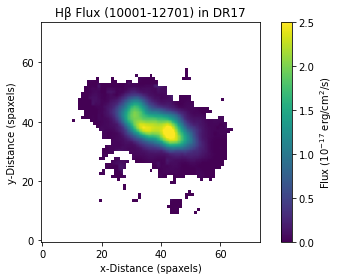

In [21]:
plt.imshow(objmaps_R['HbF']['flux'],origin='lower',vmin=0,vmax=2.5)
plt.locator_params(axis='y', nbins=5)
plt.title('H\u03B2 Flux ('+plateifu+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label=r'Flux (10$^{-17}$ erg/cm$^2$/s)')
plt.tight_layout()
plt.savefig('Thesis_Hbeta_Flux_'+plateifu+'_'+version,dpi=500)

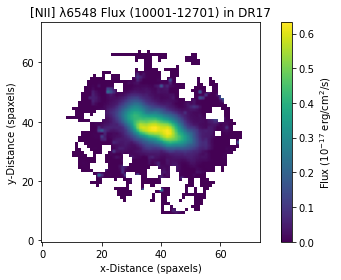

In [20]:
plt.imshow(objmaps_R['NII2']['flux'],origin='lower')#,vmin=0,vmax=5)
plt.locator_params(axis='y', nbins=5)
plt.title('[NII] \u03BB6548 Flux ('+plateifu+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label=r'Flux (10$^{-17}$ erg/cm$^2$/s)')
plt.tight_layout()
plt.savefig('Thesis_NII2_Flux_'+plateifu+'_'+version,dpi=500)

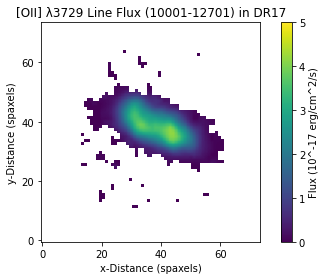

In [25]:
plt.imshow(objmaps_R['OII2']['flux'],origin='lower',vmin=0,vmax=5)
plt.locator_params(axis='y', nbins=5)
plt.title('[OII] \u03BB3729 Line Flux ('+plateifu+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='Flux (10^-17 erg/cm^2/s)')
plt.tight_layout()
plt.savefig('RSPS Presentation Figures/OII2_Flux_'+plateifu+'_'+version,dpi=500)

In [238]:
print(results_R['R']['metallicity'].data[52,29])# .data here because this is a masked spaxel
print(results_R['R']['ivar'].data[52,29])# .data here because this is a masked spaxel

7.316141446159772
0.13587833678428046


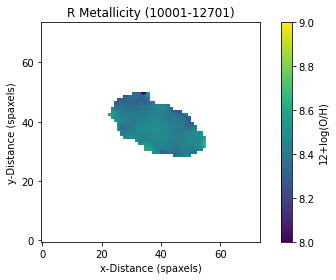

In [13]:
plt.imshow(results_R['R']['metallicity'],origin='lower',vmin=8,vmax=9)
plt.locator_params(axis='y', nbins=5)
plt.title('R Metallicity ('+plateifu+')')# in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='12+log(O/H)')
plt.tight_layout()
plt.savefig('Thesis_R_Metallicity_'+plateifu+'_'+version,dpi=500)

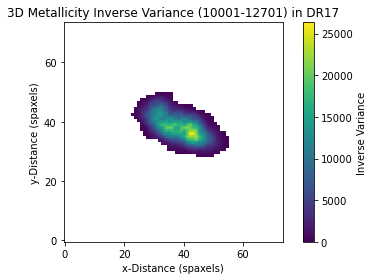

In [240]:
plt.imshow(results_R['R']['ivar'],origin='lower')#,vmin=0,vmax=1)
plt.locator_params(axis='y', nbins=5)
plt.title('3D Metallicity Inverse Variance ('+plateifu+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='Inverse Variance')
plt.tight_layout()
# plt.savefig('3Dmetallicity_'+plateifu_R+'_'+version)

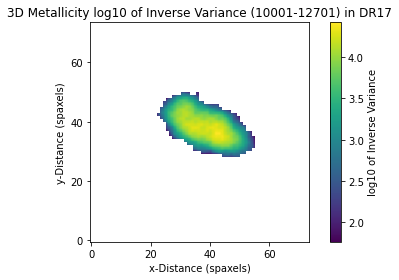

In [241]:
plt.imshow(ma.log10(results_R['R']['ivar']),origin='lower')#,vmin=2,vmax=3.5)
plt.locator_params(axis='y', nbins=5)
plt.title('3D Metallicity log10 of Inverse Variance ('+plateifu+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='log10 of Inverse Variance')
plt.tight_layout()
# plt.savefig('3Dmetallicity_'+plateifu_R+'_'+version)

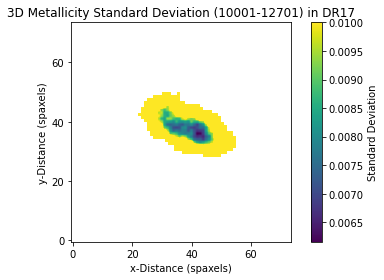

In [242]:
plt.imshow(1.0/np.sqrt(results_R['R']['ivar']),origin='lower',vmax=0.01)
plt.locator_params(axis='y', nbins=5)
plt.title('3D Metallicity Standard Deviation ('+plateifu+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='Standard Deviation')
plt.tight_layout()

In [243]:
objmaps_test = addDiagnostics_Pilyugin(plateifu)

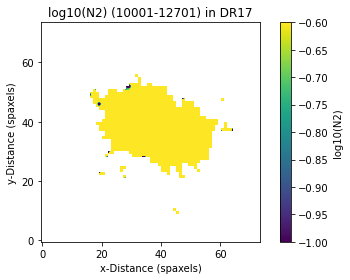

In [244]:
plt.imshow(ma.log10(objmaps_test['N2']['flux']),origin='lower',vmin=-1,vmax=-0.6)
plt.locator_params(axis='y', nbins=5)
plt.title('log10(N2) ('+plateifu+') in '+version)
plt.xlabel('x-Distance (spaxels)')
plt.ylabel('y-Distance (spaxels)')
plt.colorbar(label='log10(N2)')
plt.tight_layout()